In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.patches as patches

from scipy.stats import gaussian_kde as GKDE
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.integrate as integrate

import weightedCDFs as wCDFs
import weights

import matplotlib as mpl

In [2]:
mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

## Problem setup

In [3]:
random.seed(20)

In [4]:
l = 2.
kappa = 1.

In [5]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [6]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

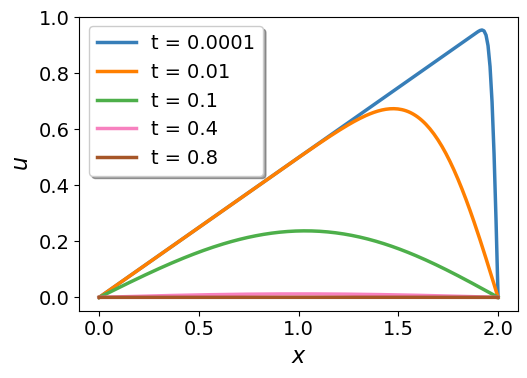

In [7]:
for t in ts:

    u_N = u(N, x, t, l, kappa)
    plt.plot(x, u_N, label='t = ' + str(t));

plt.legend(loc='upper left', shadow=True)
plt.xlabel('$x$')
plt.ylabel('$u$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/heat_eq_sol.png', bbox_inches='tight')

In [8]:
ts = [.01]
sensor_loc = 1.2

## Setup the standard DCI problem

In [9]:
n_sampling_samples = 2000

delta_l = 0.1
delta_kappa = 0.5

In [10]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, ts[0], XX[count,:], YY[count,:])

In [11]:
Xs = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 50)
Ys = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 50)

XXs, YYs = np.meshgrid(Xs, Ys)

sampling_samples = np.column_stack([XXs.flatten(), YYs.flatten()])
n_sampling_samples = len(sampling_samples)

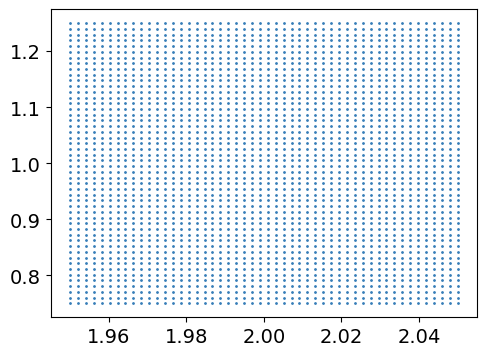

In [12]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], s=1, label='sampling')

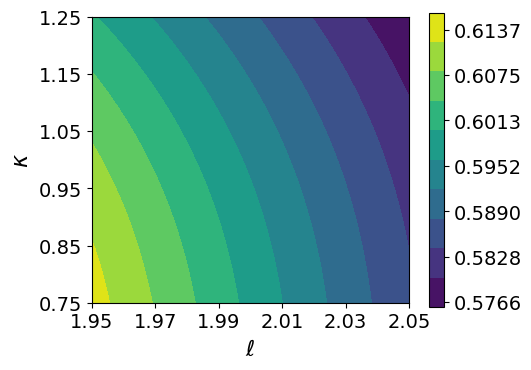

In [13]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ),
                                                             np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/contours.png', bbox_inches='tight')

In [14]:
n_init_samples = 1000

init_samples = np.zeros((n_init_samples,2))
gen_samples = np.random.beta(2, 5, (n_init_samples,2))
init_samples[:,0] = gen_samples[:,0] * delta_l + l - delta_l / 2
gen_samples = np.random.normal(0.5, 0.15, (n_init_samples,2))
init_samples[:,1] = gen_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

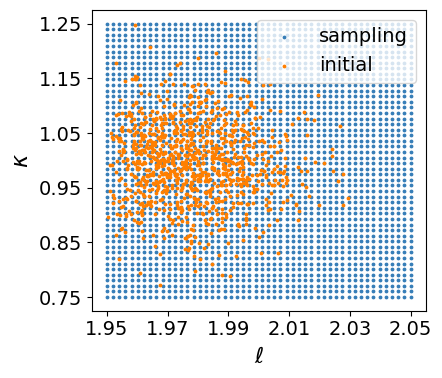

In [17]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], label='sampling', s=3)
plt.scatter(init_samples[:,0], init_samples[:,1], label='initial', s=3)
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.legend(facecolor=(1, 1, 1, 1))

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/gsearch_heat_eq_init_samples.png', bbox_inches='tight')

In [50]:
pred_samples = np.zeros((n_sampling_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc, t, sampling_samples[:,0], sampling_samples[:,1])
    
pred_KDE = GKDE(pred_samples[:,0])

In [51]:
init_pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    init_pred_samples[:, count] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    
init_pred_KDE = GKDE(init_pred_samples[:,0])

In [52]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples)

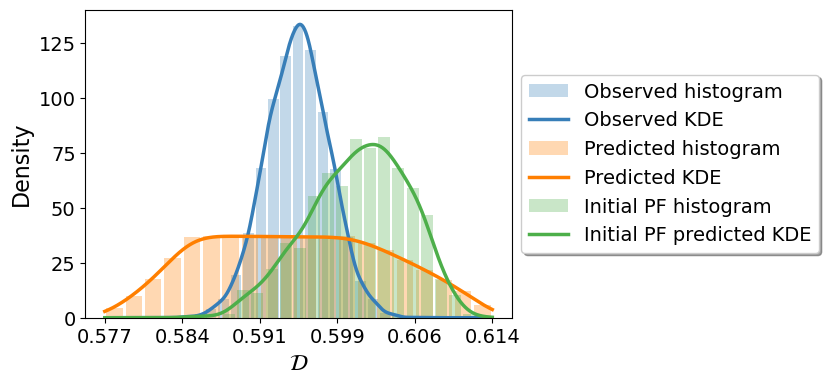

In [56]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE')

plt.hist(init_pred_samples, bins=20, alpha=0.3, density=True, label='Initial PF histogram', rwidth=0.85);
plt.plot(xx, init_pred_KDE(xx), color=CB_color_cycle[2], label='Initial PF predicted KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)])
plt.ylabel('Density')

plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_heat_eq_dists.png', bbox_inches='tight')

## Density-based solution

In [57]:
r = obs_KDE(init_pred_samples.T) / init_pred_KDE(init_pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 0.9796053532778642


In [58]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

In [62]:
update_inds = rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = init_pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

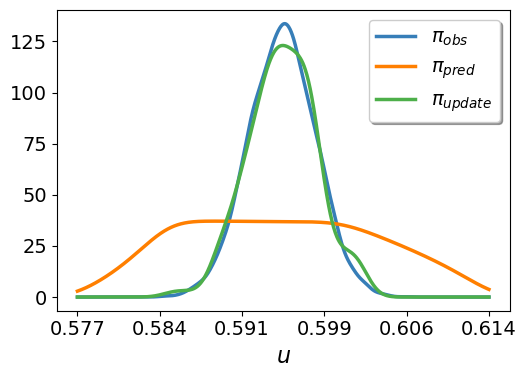

In [63]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel(r'$u$')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig('/Users/kirana/Desktop/work/paper/niid_dens_results.png', bbox_inches='tight')

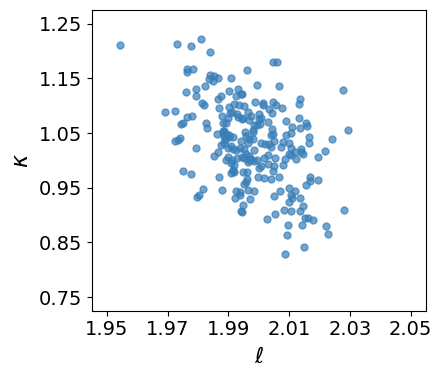

In [83]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_rejection.png', bbox_inches='tight')

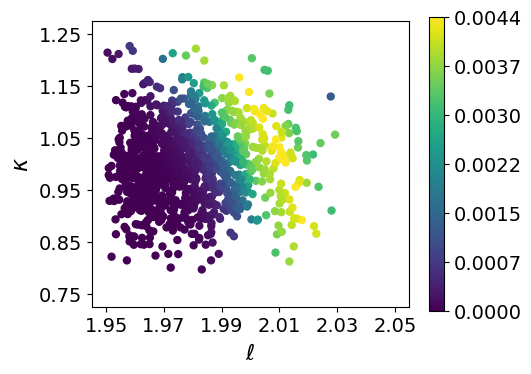

In [82]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_rn_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_8336/1956015477.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


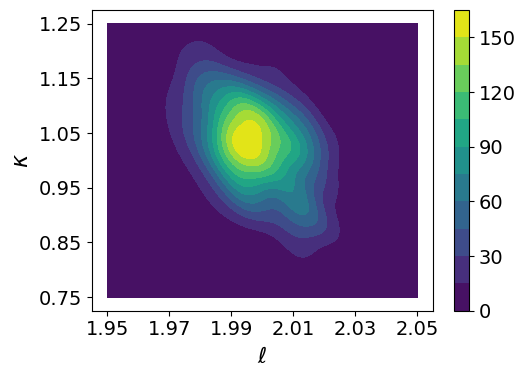

In [85]:
update_KDE = GKDE(init_samples.T, weights=rn_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_dens_wkde.png', bbox_inches='tight')

## Binning methods

In [117]:
n_bins = 20

In [118]:
np.shape(prop_samples)
np.shape(pred_samples)
np.shape(init_samples)

(1000, 2)

### Regular partitioning

In [119]:
rpartitioned_w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

computing cluster weights
     pcost       dcost       gap    pres   dres
 0: -2.0401e-01 -2.0260e+01  2e+01  2e-16  9e+00
 1: -2.0412e-01 -4.5979e-01  3e-01  1e-15  1e-01
 2: -2.1045e-01 -2.5420e-01  4e-02  7e-16  2e-02
 3: -2.2436e-01 -2.4400e-01  2e-02  3e-15  2e-17
 4: -2.2600e-01 -2.2949e-01  3e-03  1e-15  2e-17
 5: -2.2675e-01 -2.2733e-01  6e-04  3e-15  1e-17
 6: -2.2687e-01 -2.2693e-01  7e-05  1e-15  2e-17
 7: -2.2688e-01 -2.2689e-01  1e-05  2e-15  1e-17
 8: -2.2689e-01 -2.2689e-01  2e-06  1e-15  1e-17
 9: -2.2689e-01 -2.2689e-01  2e-07  2e-15  1e-17
10: -2.2689e-01 -2.2689e-01  4e-08  6e-16  1e-17
Optimal solution found.
computing initial weights
     pcost       dcost       gap    pres   dres
 0: -1.0576e-01 -2.5002e+03  3e+03  1e-15  1e+02
 1: -1.0576e-01 -2.5186e+01  3e+01  1e-14  1e+00
 2: -1.0590e-01 -4.3584e-01  3e-01  1e-14  1e-02
 3: -1.1281e-01 -1.7325e-01  6e-02  9e-15  2e-03
 4: -1.2532e-01 -1.6632e-01  4e-02  2e-14  1e-04
 5: -1.2694e-01 -1.3566e-01  9e-03  2e-14  3

In [120]:
print(np.shape(rpartitioned_w))

(2500,)


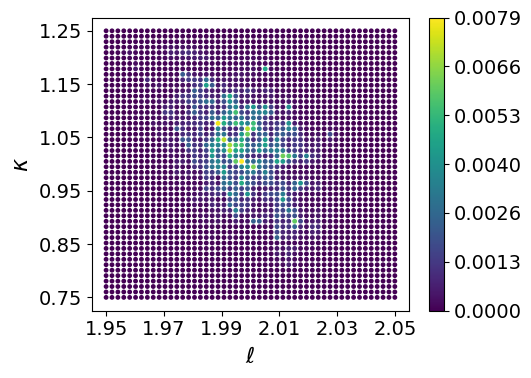

In [121]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], c=rpartitioned_w, s=6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_regpart_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_8336/1048792071.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


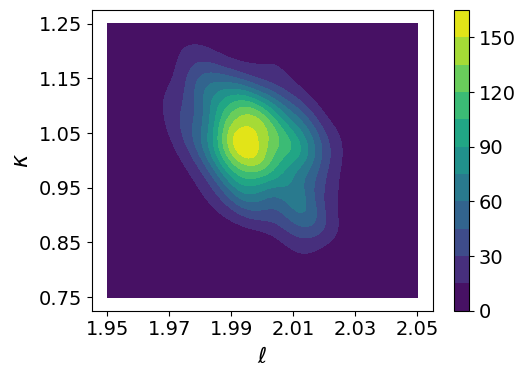

In [122]:
update_KDE = GKDE(sampling_samples.T, weights=rpartitioned_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/paper/gsearch_niid_wkde.png', bbox_inches='tight')